# 全卷积神经网络 - Fully Convolutional Network (FCN)

In [1]:
import sys
# 将当前目录添加到path

sys.path.append('/home/huqian/data/nn_code/')
sys.path

['/home/huqian',
 '/home/huqian/anaconda3/lib/python38.zip',
 '/home/huqian/anaconda3/lib/python3.8',
 '/home/huqian/anaconda3/lib/python3.8/lib-dynload',
 '',
 '/home/huqian/anaconda3/lib/python3.8/site-packages',
 '/home/huqian/anaconda3/lib/python3.8/site-packages/IPython/extensions',
 '/home/huqian/.ipython',
 '/home/huqian/data/nn_code/']

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from utils.ProgressBar import ProgressBar
from utils.ArrayPainter import convertArr2IMG
from utils.LossTracer import LossTracer

import torch.nn.functional as F

import PIL

In [3]:
a=torch.tensor([[1,2,3],[1,2,3]])
torch.sum(a>2)
len(torch.flatten(a))

6

### 1. 加载数据集

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
transform = transforms.Compose([
#     transforms.Resize((500,500)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
t_transform = transforms.Compose([
#     transforms.Resize((500,500)),
    transforms.ToTensor()
])

root = '/home/huqian/data/datasets'
train_set = torchvision.datasets.VOCSegmentation(root, year='2012', image_set='train', download=True, transform=transform,target_transform=t_transform)
test_set = torchvision.datasets.VOCSegmentation(root, year='2012', image_set='val', download=True, transform=transform,target_transform=t_transform)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True,num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True,num_workers=4)

KeyboardInterrupt: 

In [ ]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

### 2. 加载优化器和损失函数

In [7]:
model = torchvision.models.segmentation.fcn_resnet50(pretrained=True, progress=True, num_classes=21)
res = model.to(device)

# tracer = LossTracer()

In [8]:
LR= 10e-4
EPOCH = 10

lambda2 = lambda epoch: LR* (0.9 ** epoch)

optim = torch.optim.SGD(model.parameters(),lr = LR,momentum=0.09)
scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lambda2)

### 3. 训练

In [9]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [10]:
model_name = 'fcn'
model_file = model_name+'.pkl'
if os.path.exists(model_file):
    sd = torch.load(model_file)
    model.load_state_dict(sd)

# tracer.load('fcn.json')
# tracer = LossTracer()
running_loss = 0
for epoch in range(0):
    progress = ProgressBar(len(train_loader))
    for step, (img, target) in enumerate(train_loader):
        img = img.to(device)
#         img = torch.ceil(img*255)
#         target = target*255
        target = target.to(device, dtype=torch.long)
    
        optim.zero_grad()
        d = model(img)['out']
#         print('target:',d.size())
#         print('target:',target.size())
        log_p = F.log_softmax(d, dim=1)
        loss = F.nll_loss(log_p, target[0], reduction='mean')
        loss.backward()
        optim.step()
        
        running_loss += loss.item()
        
        progress.step(step+1)
        break
#     scheduler.step()
    avg_loss = running_loss/len(train_loader)
    running_loss = 0
    writer.add_scalar("Loss/train", avg_loss, tracer.epoch_base + epoch +1)
    writer.flush()
    print('EPOCH - ',tracer.epoch_base + epoch +1,'  loss is: ',avg_loss)
    tracer.append(tracer.epoch_base + epoch +1, avg_loss)
    
# tracer.epoch_base += EPOCH
# tracer.store('fcn.json')

# torch.save(model.state_dict(),model_file)

### 4. 训练损失度展示

In [11]:
for step, (img, target) in enumerate(train_loader):
    img = img.to(device)
    target = target.to(device)
    print(img.size())
    print(target.size())
    pred = model(img)
    print(pred['out'].size())
    break

torch.Size([1, 3, 333, 500])
torch.Size([1, 1, 333, 500])
torch.Size([1, 21, 333, 500])


### 5.原图和Ground-Truth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


d (375, 500)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(375, 500)
loss: 5.5576348304748535
d (375, 500)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(375, 500)
loss: 2.9284234046936035
d (375, 500)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(375, 500)
loss: 0.45452436804771423
d (375, 500)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(375, 500)
loss: 1.6786104440689087
d (322, 400)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(322, 400)
loss: 0.27990084886550903
d (375, 500)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(375, 500)
loss: 2.372126817703247
d (375, 500)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(375, 500)
loss: 2.787766456604004
d (375, 500)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(375, 500)
loss: 1.9394786357879639
d (333, 500)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(333, 500)
loss: 0.7746678590774536
d (500, 333)
(500, 333)
loss: 2.7703983783721924


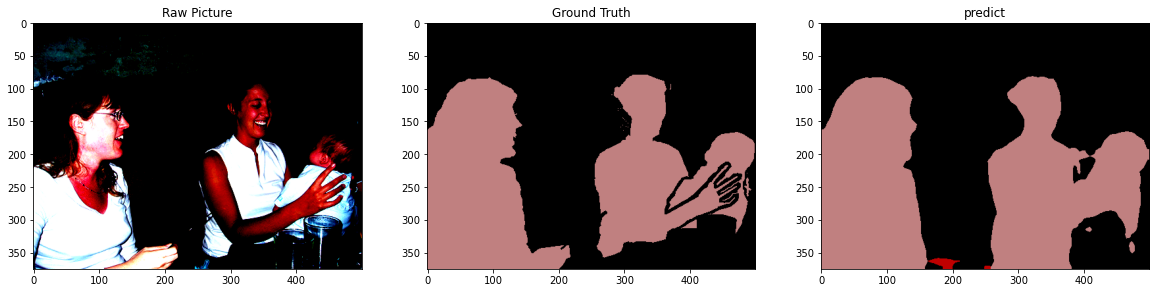

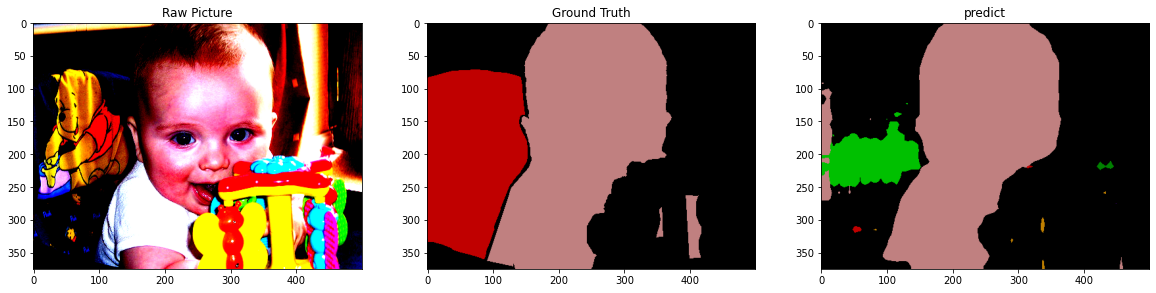

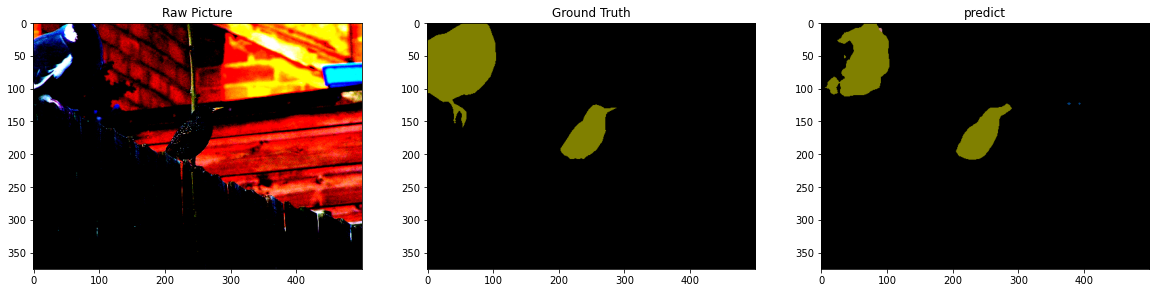

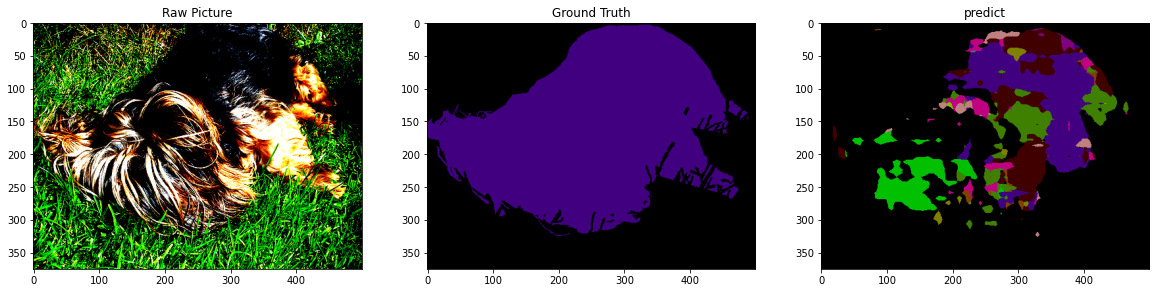

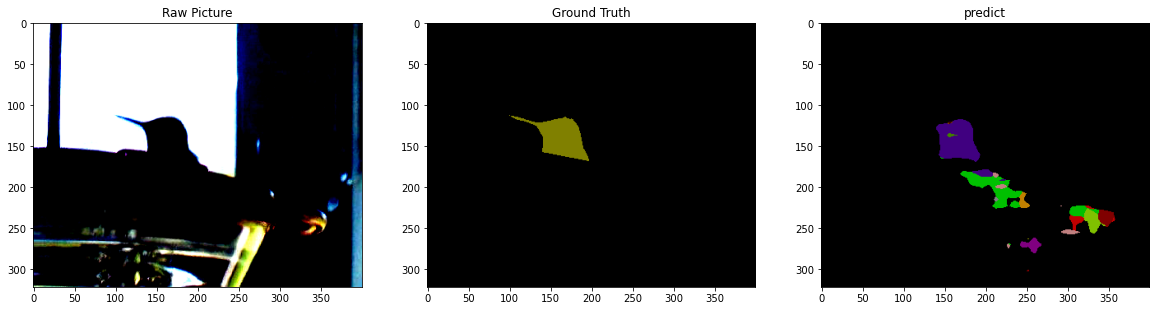

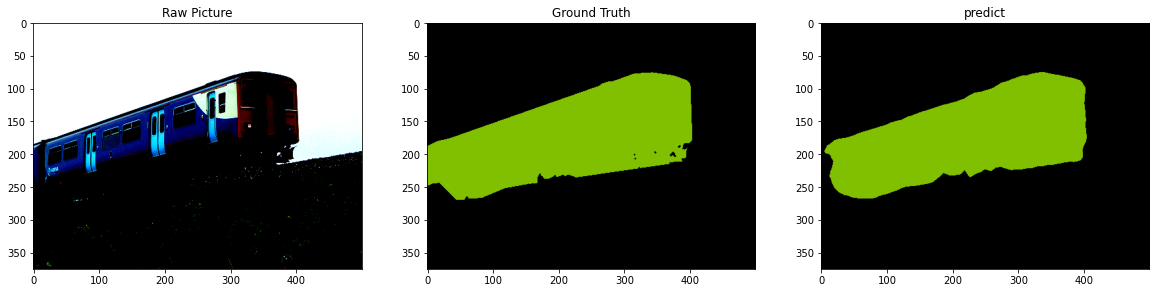

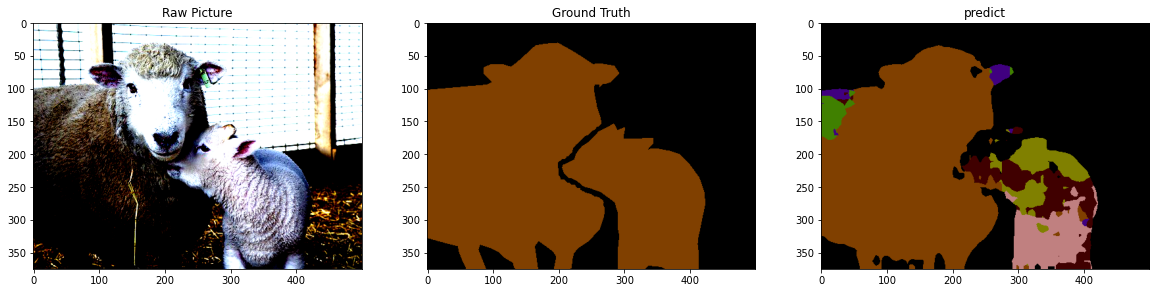

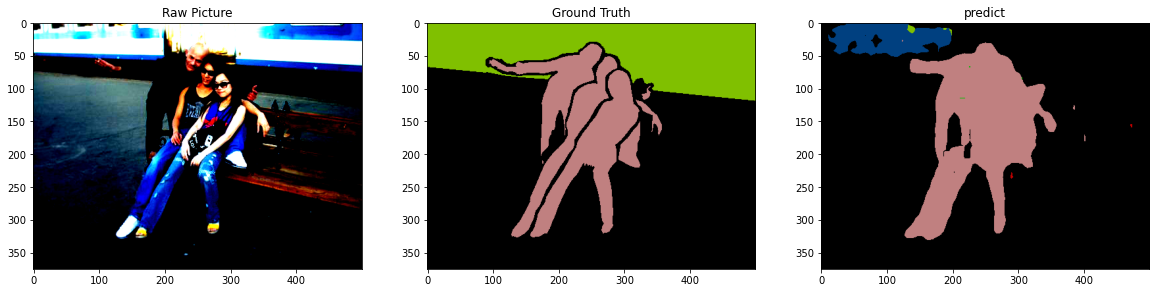

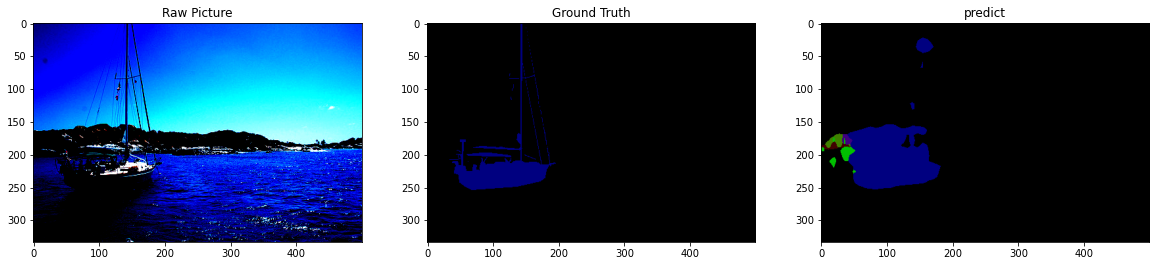

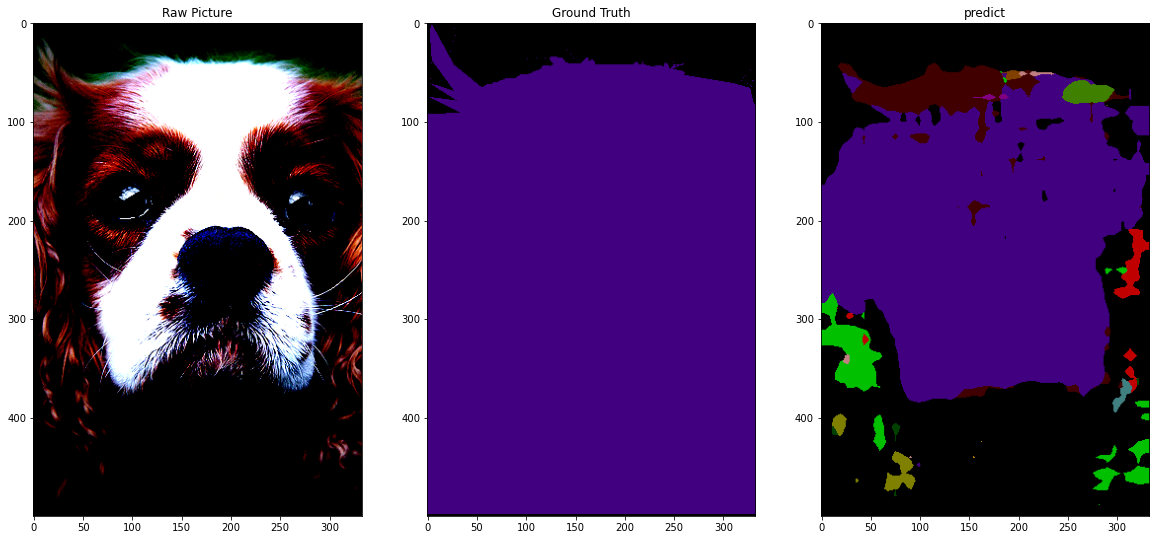

In [12]:
row = 1
for step, (img, target) in enumerate(test_loader):
    img = img.to(device)
    target = target.to(device,dtype=torch.float)
    
    # predict
    pred = model(img)

    # raw pic
    data = img[0].cpu().numpy()
    data = np.transpose(data,(1,2,0))
    plt.figure(figsize=(20,60))
    plt.subplot(1,3,1)
    plt.title('Raw Picture')
    plt.imshow(data)

    # ground-truth
    data = target[0].cpu().numpy()[0]*255 # 必须乘255，不然只有边框的信息
    data[data==255]=0
    print('d',data.shape)
    image_d = convertArr2IMG(data)
    image_d.save('pic_raw.jpg')
    data = data.astype(np.int)
    mask = decode_segmap(data)
    plt.subplot(1,3,2)
    plt.title('Ground Truth')
    plt.imshow(mask)
    
    # predict
    plt.subplot(1,3,3)
    plt.title('predict')
    out = pred['out'][0]
    x = out.clone()
    # x[0] = 0
    res = x.max(0)[1].detach().cpu().numpy()
    print(res.shape)
    # res = res.astype(np.int)
    maskr = decode_segmap(res)
    plt.imshow(maskr)
    # data.shape
    
    # loss
    target = target.to(device, dtype=torch.long)
    log_p = F.log_softmax(pred['out'], dim=1)
    loss = F.nll_loss(log_p, target[0], reduction='mean')
    print('loss:',loss.item())
    
    
    # save ground-truth num pic
#     image = convertArr2IMG(data)
#     image.save('pig_raw.jpg')
    if row == 10:
        break
    row += 1

### 6. 各个通道的信号

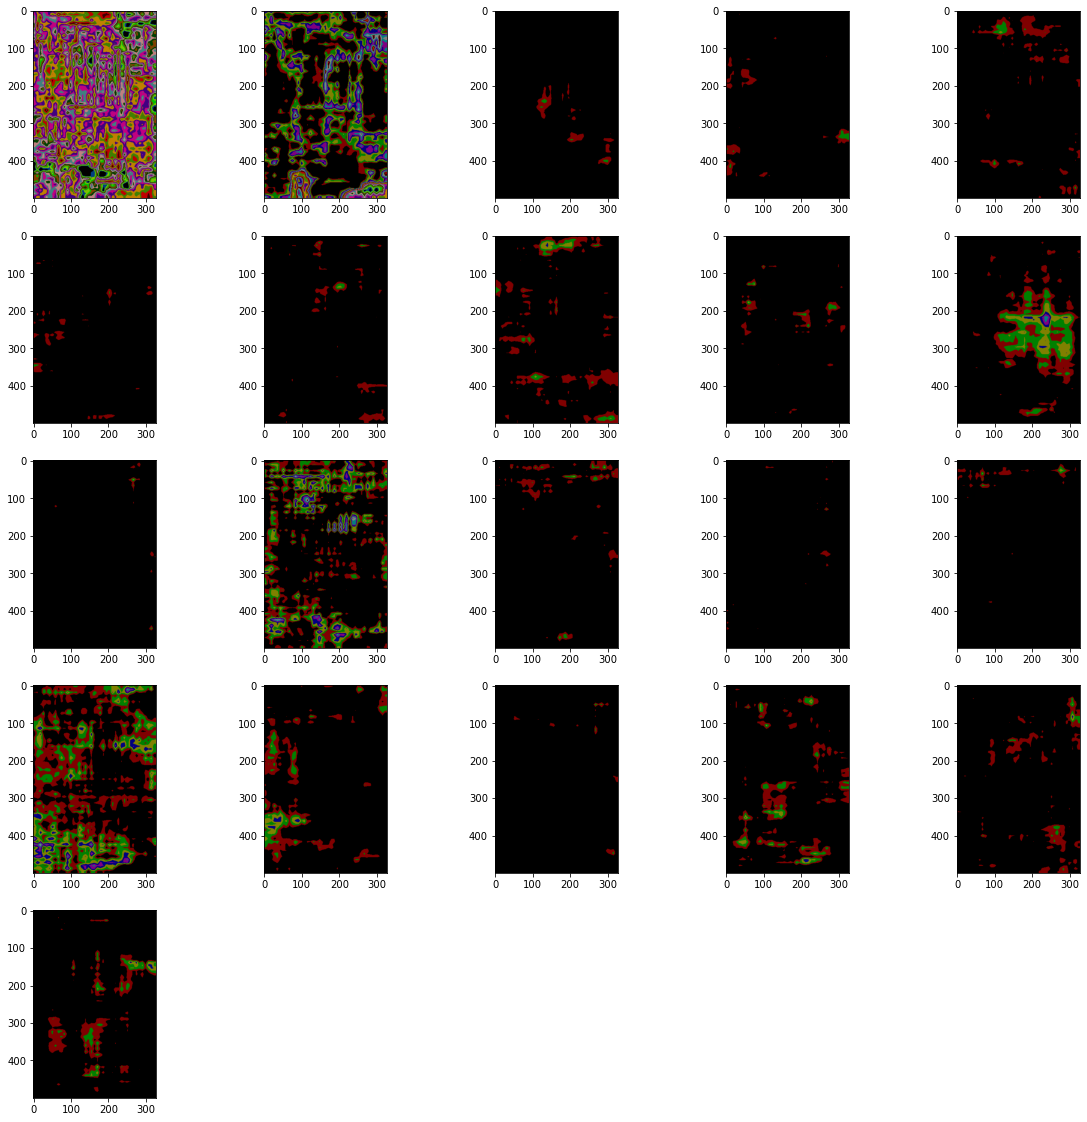

In [234]:
import torch.nn.functional as F
out = pred['out'][0]
data = out.clone().detach().cpu().numpy()
# print(data)


plt.figure(figsize=(20,20))
for idx,d in enumerate(data):
    d = d.astype(np.int)
#     print(d[d>0])
    name = 'pig_'+str(idx)+'.jpg'
#     image_d = convertArr2IMG(d)
#     image_d.save(name)
    mask = decode_segmap(d)
    plt.subplot(5,5,idx+1)
    plt.imshow(mask)

### 7. 计算精度

In [ ]:
train_loss_flag = True

In [12]:
loss_sum = 0
for step, (img, target) in enumerate(train_loss_flag if train_loader else test_loader):
    img = img.to(device)
    target = torch.round(target*255) # 小数转整数
    target[target==255] = 0 # 去除边框
    target = target.to(device,dtype=torch.float)

    # predict
    pred = model(img)
    d = pred['out'] # 预测值
    mask_pred = d.max(1)[1]
    dif = target - mask_pred
    err_num = torch.sum(dif!=0)
    err_rate = err_num.item()/len(torch.flatten(d))
#     print(err_rate)
    loss_sum += err_rate

print(loss_sum/len(train_loss_flag if train_loader else test_loader))

0.005638402942730997
